In [1]:
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps
import os, sys, math, random, copy, time
import datasets, custom_transforms, models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Settings

In [2]:
# CKPT for vlassifier
#description = 'DanielCustomNetwork_Original_VGG16Rajaraman'
#CKPT_filename = 'balance[epoch_10_loss_0.059_acc_0.990]'+'.pt'

training_data = "None"

description = 'VGG16_Rajaraman_'+training_data
if training_data is "None":
    CKPT_filename = 'balance[epoch_12_loss_0.090_acc_0.990]'+'.pt' #'balance[epoch_4_loss_0.060_acc_0.980]'+'.pt'
elif training_data is "Gusarev":
    CKPT_filename = 'balance[epoch_12_loss_0.058_acc_0.990]'+'.pt'
elif training_data is "Rajaraman":
    CKPT_filename = 'balance[epoch_12_loss_0.066_acc_0.990]'+'.pt'#'balance[epoch_6_loss_0.055_acc_0.985]'+'.pt'

max_layers_to_freeze = 28


# SETTINGS
N_CLASSES = 2
unbias_dataset = False # False to use ALL data in the dataset, True to cut the number of elements in each set to roughly the same number.
CLASS_NAMES = ['NONCOVID', 'COVID' ]#['Normal', 'Pneumonia', 'COVID-19'] #  in order of 0, 1, 2
BATCH_SIZE = 16
switch_pair = ["internal_test_Daniel", "NoSuppression", "Gusarev", "Rajaraman"]
interp_mode = torchvision.transforms.InterpolationMode.NEAREST
top_cutoff_percent = 0.08
image_size_to_VGG = 224


CKPT_PATH = os.path.join(description , str(max_layers_to_freeze), CKPT_filename)
CKPT_PATH = os.path.join('checkpoints', str(N_CLASSES)+"Class", CKPT_PATH)
print(CKPT_PATH)
# Dataset saving directories
save_picture_directory = Path(os.path.join("reports", str(N_CLASSES)+"Class", str(description))) # directory to save confusion matrices
save_picture_directory.mkdir(parents=True, exist_ok=True)


# Transforms
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]) # ImageNet mean and std for normalisation
test_transforms = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            custom_transforms.COVIDNetProcessing(top_cutoff_percent),
                            torchvision.transforms.Resize(image_size_to_VGG, interpolation=interp_mode),
                            torchvision.transforms.CenterCrop(image_size_to_VGG),
                            normalize,
                            ])

checkpoints\2Class\VGG16_Rajaraman_None\28\balance[epoch_12_loss_0.090_acc_0.990].pt


# Datasets

In [3]:
dataset_normal={
    "NoSuppression":"D:/data/DanielBoneSuppressedData/NoSuppression/JSRT_all_noSuppression_20210805_nearest_uncropped/",
    "Gusarev":"../GusarevBoneSuppression/bone_suppressed/JSRT_all_v5_HQ_nonEqualised_noInputHistEq_177-20-20_20210805_uncropped/",
    "Rajaraman":"../Rajaraman_ResNet_BS/bone_suppressed/JSRT_all_v2_HQ_notEqualised_inputsNotEqualised_177-20-20_20210805_nearest_uncropped/",
               }
dataset_pneumonia={
    "NoSuppression":None,
    "Gusarev":None,
    "Rajaraman":None,
                  }
dataset_covid={
    "NoSuppression":"D:/data/DanielBoneSuppressedData/NoSuppression/QEH_onePerPatient_all_noSuppression_20210805_nearest_uncropped/",
    "Gusarev":"../GusarevBoneSuppression/bone_suppressed/QEH_onePerPatient_all_v5_HQ_nonEqualised_noInputHistEq_177-20-20_20210805_uncropped/",
    "Rajaraman":"../Rajaraman_ResNet_BS/bone_suppressed/QEH_onePerPatient_all_v2_HQ_notEqualised_inputsNotEqualised_177-20-20_20210805_nearest_uncropped/",
              }

def switchDataset(switch, dataset_normal=None, dataset_pneumonia=None, dataset_covid=None, training_data=None):
    if switch == "internal_test_Daniel":
        data_normal = "D:/data/DanielCustomNetwork/DanielDataSets_Reduced_256_"+str(training_data_text)+"/test/NORMAL/"
        data_pneumonia = "D:/data/DanielCustomNetwork/DanielDataSets_Reduced_256_"+str(training_data_text)+"/test/PNEUMONIA/"
        data_covid = "D:/data/DanielCustomNetwork/DanielDataSets_Reduced_256_"+str(training_data_text)+"/test/COVID/"
    else:
        data_normal = dataset_normal[switch]
        data_pneumonia = dataset_pneumonia[switch]
        data_covid = dataset_covid[switch]
    return {'normal': data_normal, 'pneumonia': data_pneumonia, 'covid': data_covid}

# Model

In [4]:
model = models.VGG16_Rajaraman(N_CLASSES, max_layer_to_freeze=max_layers_to_freeze, verbose=False)
model = model.to(device)
model.eval()
if os.path.isfile(CKPT_PATH):
    print("=> loading checkpoint")
    checkpoint = torch.load(CKPT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("=> loaded checkpoint")
else:
    raise RuntimeError("=> no checkpoint found")
    
print("Model Loaded.")

Parameters total:  14715714
Parameters trainable:  2360834
=> loading checkpoint
=> loaded checkpoint
Model Loaded.


In [5]:
try:
    print("LR:{} , Batch Size:{}, Class Weights:{}, FrozenLayers:{}, Num Classes:{}".format(checkpoint["ini_lr"],
                        checkpoint["BATCH_SIZE"], checkpoint['class_weights'], checkpoint["max_layers_to_freeze"], checkpoint["N_CLASSES"]))
except:
    print("Missing one of the dict keys")
print(checkpoint["optimizer_state_dict"]["param_groups"])

LR:0.001 , Batch Size:4, Class Weights:tensor([1.0000, 1.1161], device='cuda:0'), FrozenLayers:28, Num Classes:2
[{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]}]


# Training

In [6]:
predictions = {}
true_labels={}
for switch in switch_pair:
    # What is the training data used to train the network?
    if training_data is not None:
        if training_data is "NoSuppression":
            training_data_text = "None"
        else:
            training_data_text = training_data
    # Dataset
    chosen_datasets = switchDataset(switch, dataset_normal, dataset_pneumonia, dataset_covid, training_data_text)
    test_dataset = datasets.Coviddataset(normal_path=chosen_datasets["normal"], pneumonia_path=chosen_datasets["pneumonia"], covid_path=chosen_datasets["covid"], 
                                         transform = test_transforms, NClasses=N_CLASSES, 
                                         unbias=unbias_dataset, channels=3) # RGB image
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=0, pin_memory=True)
    
    # Classify
    predictions[switch] = []
    true_labels[switch] = []
    for data in test_loader:
        inputs, labels, names = data['image'], data['label'], data['name']
        inputs = inputs.to(device)
        with torch.no_grad():
            preds = model(inputs)
            preds = preds.detach().clone()
            preds = torch.argmax(preds,1,False)
        
        # Append lists
        predictions[switch].append(preds.detach().cpu())
        true_labels[switch].append(labels.detach().cpu())
    predictions[switch] = torch.cat(predictions[switch])
    true_labels[switch] = torch.cat(true_labels[switch])
    

RAW DATASET STATISTICS:-----------
Normal:100, Pneumonia:100, COVID:100
2-Class Dataset Statistics:-----------
Noncovid:200, COVID:100


C:\Users\nfdlam\.conda\envs\AI_cuda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


None Path
RAW DATASET STATISTICS:-----------
Normal:241, Pneumonia:0, COVID:524
2-Class Dataset Statistics:-----------
Noncovid:241, COVID:524
None Path
RAW DATASET STATISTICS:-----------
Normal:241, Pneumonia:0, COVID:524
2-Class Dataset Statistics:-----------
Noncovid:241, COVID:524
None Path
RAW DATASET STATISTICS:-----------
Normal:241, Pneumonia:0, COVID:524
2-Class Dataset Statistics:-----------
Noncovid:241, COVID:524


In [ ]:
"""
Created on Tue Nov  6 10:06:52 2018

@author: yandexdataschool

Original Code found in:
https://github.com/yandexdataschool/roc_comparison

updated: Raul Sanchez-Vazquez
"""

import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


alpha = .95
for switch in switch_pair:
    print(switch)
    y_pred = predictions[switch]
    y_true = true_labels[switch]

    auc, auc_cov = delong_roc_variance(
        y_true,
        y_pred)

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    ci[ci > 1] = 1

    print('AUC:', auc)
    print('AUC COV:', auc_cov)
    print('95% AUC CI:', ci)

# Visualisation

Calculating...


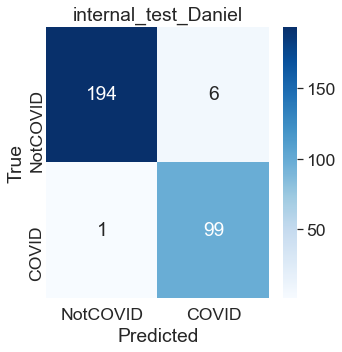

Confusion Matrix:
[[194   6]
 [  1  99]]
Sensitivity: 99.00%
Specificity: 97.00%
NPV: 99.49%
Accuracy: 97.67%


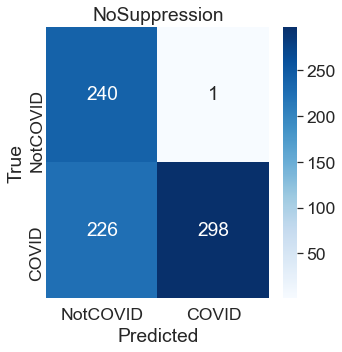

Confusion Matrix:
[[240   1]
 [226 298]]
Sensitivity: 56.87%
Specificity: 99.59%
NPV: 51.50%
Accuracy: 70.33%


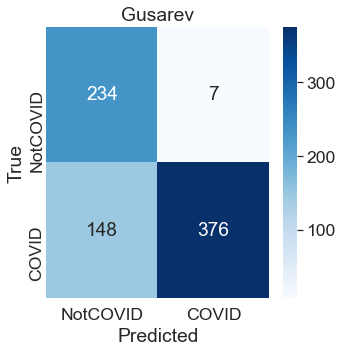

Confusion Matrix:
[[234   7]
 [148 376]]
Sensitivity: 71.76%
Specificity: 97.10%
NPV: 61.26%
Accuracy: 79.74%


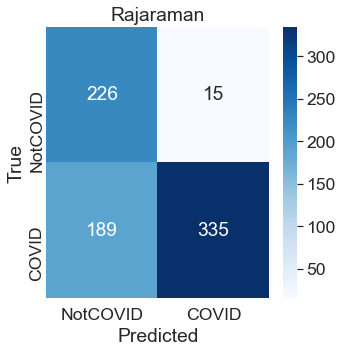

Confusion Matrix:
[[226  15]
 [189 335]]
Sensitivity: 63.93%
Specificity: 93.78%
NPV: 54.46%
Accuracy: 73.33%
NoSuppression-Gusarev
T-score : 4.410214678910138
McNemar Contingency Table:---
[[155 144]
 [228 238]]
McNemar Chi-Squared : 18.518817204301076
NoSuppression-Rajaraman
T-score : 2.6527980817125263
McNemar Contingency Table:---
[[138 161]
 [212 254]]
McNemar Chi-Squared : 6.702412868632708
Gusarev-Rajaraman
T-score : 1.6982885383875792
McNemar Contingency Table:---
[[177 206]
 [173 209]]
McNemar Chi-Squared : 2.7018469656992083
Complete
                   Name  Sensitivity  Specificity       NPV  Accuracy
0  internal_test_Daniel     0.990000     0.970000  0.994872  0.976667
1         NoSuppression     0.568702     0.995851  0.515021  0.703268
2               Gusarev     0.717557     0.970954  0.612565  0.797386
3             Rajaraman     0.639313     0.937759  0.544578  0.733333


In [7]:
from sklearn.metrics import confusion_matrix 
#import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(font_scale=1.6)
def prediction_outputs(preds, true_labels=None, n_class = 2, title="", save_file=None, plot_figure=False, verbose=True):
    if true_labels is not None:
        if preds.ndim ==2:
            preds_closest_ints = preds.argmax(axis=1)
        elif preds.ndim==1:
            preds_closest_ints = preds
        idx = preds_closest_ints == true_labels
        
        CM = confusion_matrix(true_labels, preds_closest_ints)
        
        if plot_figure:
            fig = plt.figure(figsize=(5,5))
            ax = plt.axes()
            hm = sns.heatmap(CM, annot=True, 
                        fmt='d', cmap='Blues')
            hm.set_title(title)
            hm.set_xlabel("Predicted")
            hm.set_ylabel("True")
            hm.set_xticklabels(labels=("NotCOVID","COVID"), ha='center')
            hm.set_yticklabels(labels=("NotCOVID","COVID"), ha='center', rotation=90)
            #ax.set(title=title, xlabel="Predicted", ylabel="True")
            if save_file is not None:
                plt.savefig(fname=save_file)
            plt.show()
        
        num_classes = []
        if n_class == 2:
            num_classes.append(CM[0][0] + CM[0][1])
            num_classes.append(CM[1][0] + CM[1][1])
            
            sensitivity = CM[1][1]/(CM[1][1] + CM[1][0]) # TP/(TP+FN)
            specificity = CM[0][0]/(CM[0][0] + CM[0][1]) # TN/(TN+FP)
            NPV = CM[0][0]/(CM[0][0] + CM[1][0]) # TN/(TN+FN)
            overacc =(CM[0][0]+CM[1][1])/ (num_classes[0]+num_classes[1])
        if n_class == 3:
            overacc =(CM[0][0]+CM[1][1]+CM[2][2])/ (num_classes[0]+num_classes[1]+num_classes[2])
        if verbose:
            print("Confusion Matrix:")
            print(CM)
            print('Sensitivity: {sens:.2f}%'.format(sens=sensitivity*100))
            print('Specificity: {spec:.2f}%'.format(spec=specificity*100))
            print('NPV: {npv:.2f}%'.format(npv=NPV*100))
            print('Accuracy: {acc:.2f}%'.format(acc=overacc*100))
        
        outputs={"CM":CM, "Sensitivity":sensitivity, "Specificity":specificity, "NPV":NPV, "Accuracy":overacc}
        return outputs
    else:
        if n_class ==2:
            idx_nonCovid = preds[:,0] > preds[:,1]
            idx_Covid =  preds[:,0] <= preds[:,1]
            print("Proportion classed as non-COVID: " +str(np.sum(idx_nonCovid)/len(idx_nonCovid)))
            print("Proportion classed as COVID: " +str(np.sum(idx_Covid)/len(idx_Covid)))
        if n_class ==3:
            # 3 class
            idx_normal = np.logical_and( preds[:,0] > preds[:,1] , preds[:,0] > preds[:,2])
            idx_pneumonia = np.logical_and( preds[:,1] > preds[:,0] , preds[:,1] > preds[:,2])
            idx_COVID = np.logical_and( preds[:,2] > preds[:,1] , preds[:,2] > preds[:,0])

            print("Proportion classed as normal: " +str(np.sum(idx_normal)/len(idx_normal)))
            print("Proportion classed as pneumonia: " +str(np.sum(idx_pneumonia)/len(idx_pneumonia)))
            print("Proportion classed as COVID: " +str(np.sum(idx_COVID)/len(idx_COVID)))

def paired_t_test(array1, array2):
    #array1 = array1.argmax(axis=1)
    #array2 = array2.argmax(axis=1)
    
    x_diff = array1 - array2
    s_diff = np.std(x_diff)
    x_diff_mean = np.mean(x_diff)
    s_x = s_diff/np.sqrt(len(x_diff))
    
    t_score = np.abs(x_diff_mean/s_x)
    return t_score

def McNemar_test(test1, test2, negative_label=0, positive_label=1):
    #test1 = test1.argmax(axis=1)
    #test2 = test2.argmax(axis=1)
    
    test1_negative = test1==negative_label
    test1_positive = test1==positive_label
    test2_negative = test2==negative_label
    test2_positive = test2==positive_label
    
    # Contingency Table
    a = np.logical_and(test1_positive,test2_positive)
    b = np.logical_and(test1_positive,test2_negative)
    c = np.logical_and(test1_negative,test2_positive)
    d = np.logical_and(test1_negative,test2_negative)
    
    # McNemar Table:
    a = np.sum(a); b = np.sum(b) ; c = np.sum(c) ; d=np.sum(d)
    print("McNemar Contingency Table:---")
    print(np.asarray([[a,b],[c,d]]))
    return (np.abs(b-c)-1)**2/(b+c)


# Calculate DL-only classification
print("Calculating...")
pandas_dict = {"Name":[], "Sensitivity":[], "Specificity":[], "NPV": [], "Accuracy":[]}
for counter, status in enumerate(switch_pair):
    a = Path(os.path.join(save_picture_directory))
    a.mkdir(parents=True, exist_ok=True)
    output = prediction_outputs(predictions[status].numpy(), true_labels[status].numpy() , 2, title=status, save_file=os.path.join(a,status+".png"))
    #if counter > 0:
    #    print("T-score {}: {}".format(status,paired_t_test(predictions["Baseline"].numpy(), predictions[status].numpy())))
    #    print("McNemar Chi-Squared {}: {}".format(status,McNemar_test(predictions["Baseline"].numpy(), predictions[status].numpy())))
    print("====================")
    # output to pandas
    pandas_dict["Name"].append(status)
    pandas_dict["Sensitivity"].append(output["Sensitivity"])
    pandas_dict["Specificity"].append(output["Specificity"])
    pandas_dict["NPV"].append(output["NPV"])
    pandas_dict["Accuracy"].append(output["Accuracy"])
    

for i, switch_i in enumerate(switch_pair):
    if i == 0:
        continue
    for switch_j in switch_pair[i+1:]:
        print("{}-{}".format(switch_i, switch_j))
        print("T-score : {}".format( paired_t_test(predictions[switch_i].numpy(), predictions[switch_j].numpy())))
        print("McNemar Chi-Squared : {}".format( McNemar_test(predictions[switch_i].numpy(), predictions[switch_j].numpy())))
print("Complete")
df = pd.DataFrame(pandas_dict)
print(df)

In [8]:
print(str(None))

None
